# 데이터마이닝 : Term Project
## 2019170812 산업경영공학부 이종근
### Diabetes 분석

## Import Libraries

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc

In [186]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve

In [148]:
font_path = "/Users/onmywave/Library/Fonts/NanumSquare_acL.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

## EDA

In [149]:
df = pd.read_csv('./diabetes.csv')


### 데이터 타입 확인 및 Null Count

In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### 단변량 통계

In [151]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [152]:
desc_df = pd.DataFrame(df.describe())
# desc_df.to_excel('desc_df.xlsx')

In [155]:
df_col = list(set(df.columns) - set(['Outcome']))
df_col

['Glucose',
 'BMI',
 'Pregnancies',
 'DiabetesPedigreeFunction',
 'SkinThickness',
 'Age',
 'Insulin',
 'BloodPressure']

### Distplot, Box Plot, Probability Plot

Text(0.5, 0.98, 'distplot, Box Plots, Prob Plot')

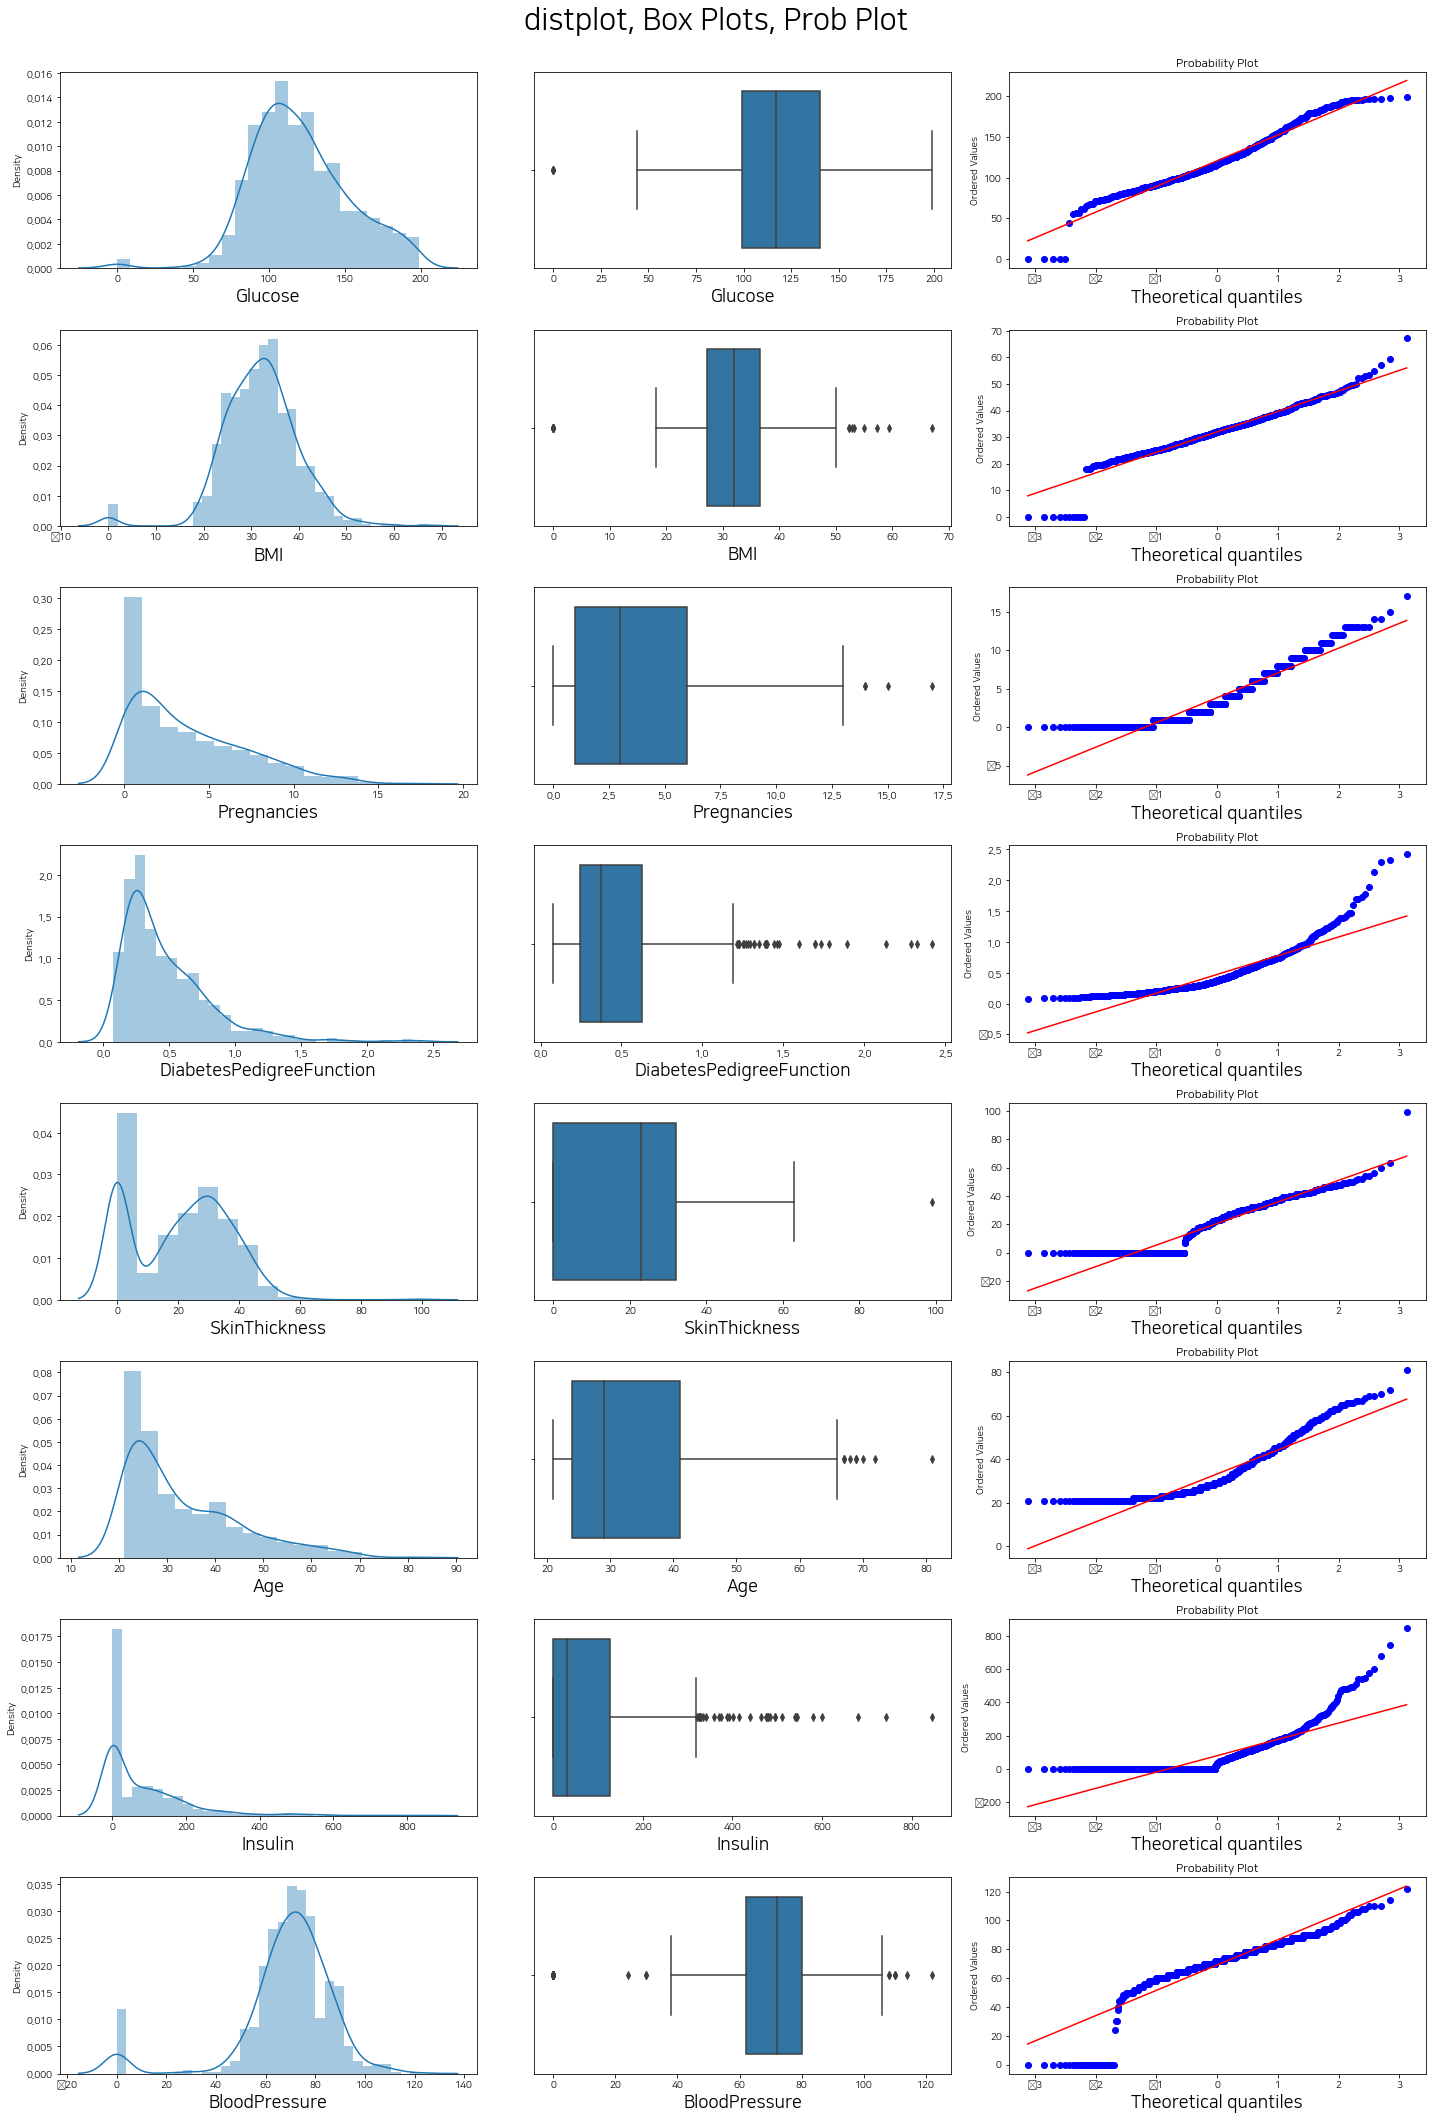

In [156]:
import warnings
import scipy.stats as stats
warnings.filterwarnings('ignore')
fig,ax = plt.subplots(8,3,figsize=(20,30))
for i in range(8):
    sns.distplot(df[df_col[i]],ax=ax[i,0])
    sns.boxplot(df[df_col[i]],ax=ax[i,1])
    stats.probplot(df[df_col[i]],plot=ax[i,2])
    ax[i, 0].xaxis.label.set_size(18)
    ax[i, 1].xaxis.label.set_size(18)
    ax[i, 2].xaxis.label.set_size(18)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.suptitle("distplot, Box Plots, Prob Plot",fontsize=30)

### Skewness, Kurtosis

In [157]:
df.skew(axis=0).sort_values()

BloodPressure              -1.843608
BMI                        -0.428982
SkinThickness               0.109372
Glucose                     0.173754
Outcome                     0.635017
Pregnancies                 0.901674
Age                         1.129597
DiabetesPedigreeFunction    1.919911
Insulin                     2.272251
dtype: float64

In [137]:
df.kurt(axis=0).sort_values()

Outcome                    -1.600930
SkinThickness              -0.520072
Pregnancies                 0.159220
Glucose                     0.640780
Age                         0.643159
BMI                         3.290443
BloodPressure               5.180157
DiabetesPedigreeFunction    5.594954
Insulin                     7.214260
dtype: float64

In [138]:
skew_curt = pd.DataFrame({'skew':df.skew(axis=0).sort_values(),'kurt':df.kurt(axis=0).sort_values()})

In [139]:
skew_curt

,skew,kurt
Age,1.129597,0.643159
BMI,-0.428982,3.290443
BloodPressure,-1.843608,5.180157
DiabetesPedigreeFunction,1.919911,5.594954
Glucose,0.173754,0.640780
Insulin,2.272251,7.214260
Outcome,0.635017,-1.600930
Pregnancies,0.901674,0.159220
SkinThickness,0.109372,-0.520072


In [140]:
# skew_curt.to_excel('skew_curt.xlsx')

### Correlation

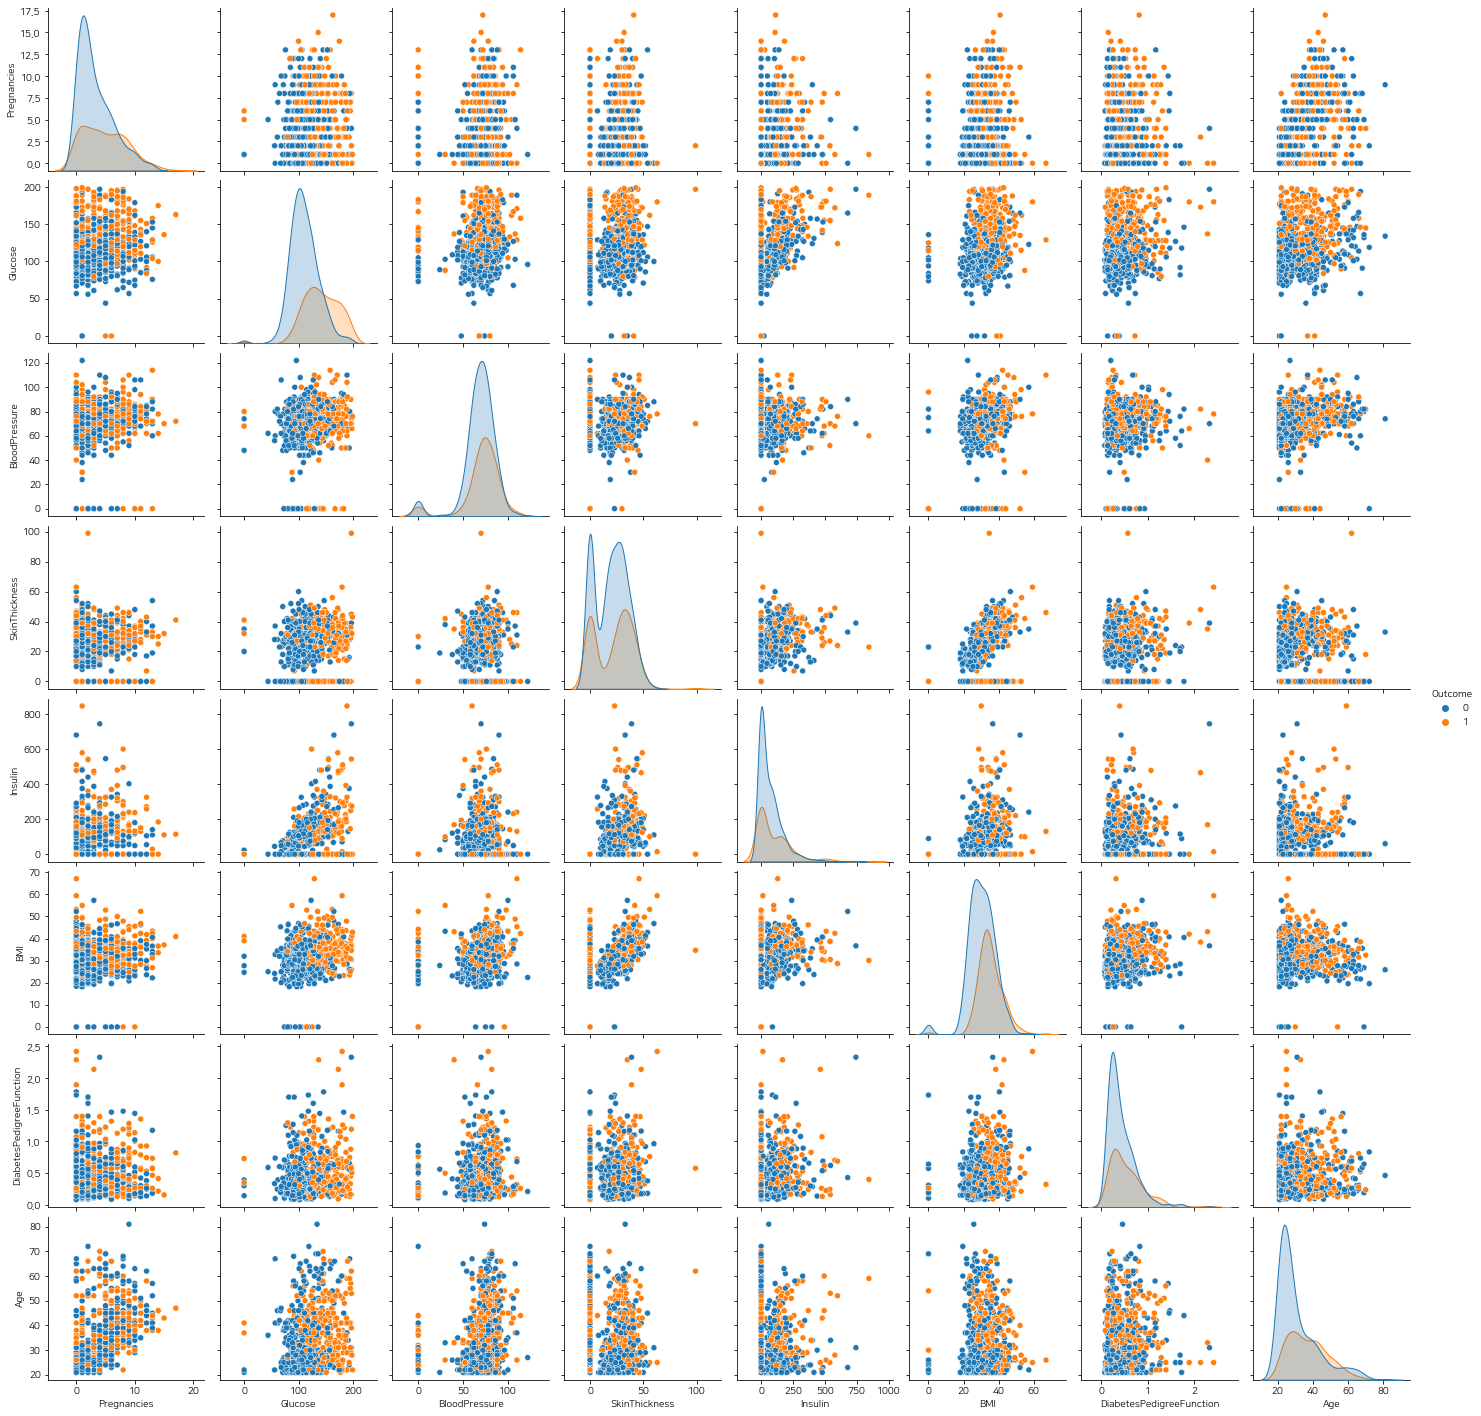

In [159]:
sns.pairplot(df, hue='Outcome')

<AxesSubplot:>

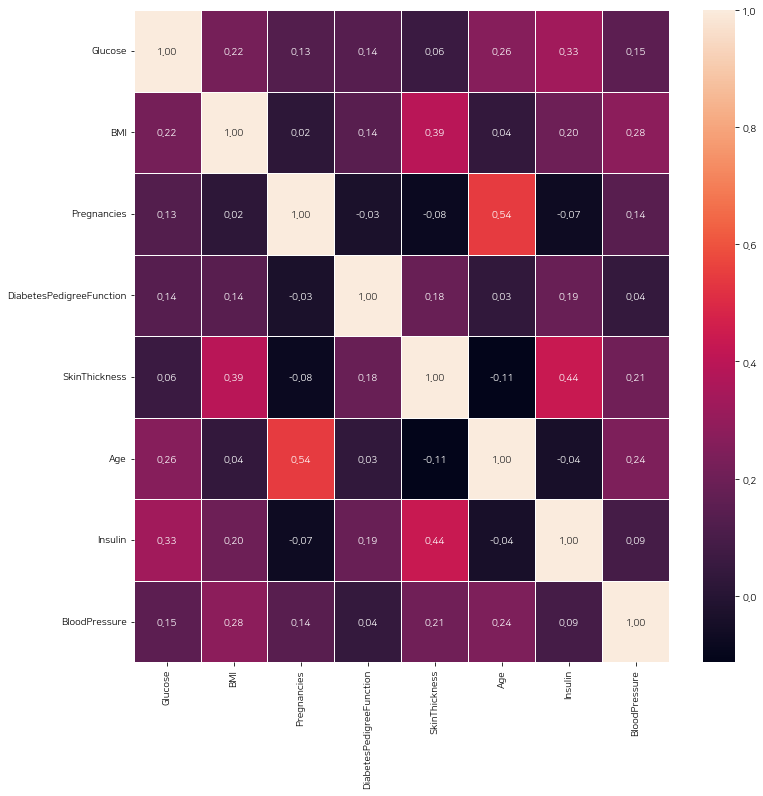

In [179]:
plt.figure(figsize=(12,12))
sns.heatmap(df.loc[:,df_col].corr(),annot=True,linewidth=0.5,fmt="0.2f")

## Data Preprocessing

### 이상치 제거

In [170]:
quartile_1 = df.quantile(0.25)
quartile_3 = df.quantile(0.75)
IQR = quartile_3 - quartile_1
condition = (df < (quartile_1 - 2 * IQR)) | (df > (quartile_3 + 2 * IQR))
condition = condition.any(axis=1)


insul_IQR = df['Insulin'].quantile(0.75) - df['Insulin'].quantile(0.25)
insulin_cond = (df['Insulin'] < (df['Insulin'].quantile(0.25) - 3 * insul_IQR)) | (df['Insulin'] > (df['Insulin'].quantile(0.75) + 3 * insul_IQR))

search_df = df[condition & ~insulin_cond]

print(len(search_df))

76


In [176]:
removed_df = df.drop(search_df.index)

In [177]:
removed_df.shape

(692, 9)

### MinMaxScaler

In [183]:
from sklearn.preprocessing import MinMaxScaler

scaled_df = MinMaxScaler().fit_transform(removed_df)

df_normalized = pd.DataFrame(scaled_df, columns=df.columns)
df_normalized

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.400000,0.675325,0.500000,0.583333,0.000000,0.418478,0.243892,0.591837,1.0
1,0.066667,0.266234,0.428571,0.483333,0.000000,0.228261,0.121279,0.204082,0.0
2,0.533333,0.902597,0.404762,0.000000,0.000000,0.138587,0.263883,0.224490,1.0
3,0.066667,0.292208,0.428571,0.383333,0.111111,0.269022,0.039538,0.000000,0.0
4,0.333333,0.467532,0.523810,0.000000,0.000000,0.201087,0.054642,0.183673,0.0
...,...,...,...,...,...,...,...,...,...
687,0.666667,0.370130,0.547619,0.800000,0.212766,0.399457,0.041315,0.857143,0.0
688,0.133333,0.506494,0.476190,0.450000,0.000000,0.505435,0.116393,0.122449,0.0
689,0.333333,0.500000,0.500000,0.383333,0.132388,0.217391,0.074189,0.183673,0.0
690,0.066667,0.532468,0.357143,0.000000,0.000000,0.323370,0.120391,0.530612,1.0


### 데이터셋 분리

In [187]:
# Load the data & Preprocessing
columns = df.columns.values
input_idx = [i for i in range(8)]
target_idx = 8

df_input = df_normalized[columns[input_idx]]
df_target = df_normalized[columns[target_idx]]

In [190]:
X_train, X_test, y_train, y_test = train_test_split(df_input, 
                                                    df_target,
                                                    test_size=0.3,
                                                    stratify=df_target,
                                                    random_state=2019170812)

## Classification

In [208]:
from typing import Union

# Performance evaluation function for Classification

def perf_eval_clf(y_true: Union[np.array,list], y_pred: Union[np.array,list])->list:
    """
    Input:
    y_true : ndarray of shape (n_samples,)
    y_pred : ndarray of shape (n_samples,)

    Return:
    [TPR,Precision,TNR, Accuracy, BCR, F1]: scores of classification in a list
    """
    tn, fp, fn, tp = confusion_matrix(y_true = y_true, y_pred = y_pred).ravel()
    TPR = round(tp/(tp+fn),4)
    PRE = round(tp/(tp+fp),4)
    TNR = round(tn/(fp+tn),4)
    ACC = round((tp+tn)/(tn+fp+fn+tp),4)
    BCR = round(np.sqrt([TPR*TNR])[0],4)
    F1 = round(2*TPR*PRE/(TPR+PRE),4)

    
    return [TPR,PRE,TNR,ACC,BCR,F1]

In [212]:

def display_result(result_dict: dict, metric_names: list):
    """
    Input:
    result_dict : 데이터 셋 별 classification 평가 결과 저장한 dictionary
    
    metric_names : Classification 평가 지표 이름 List
    ex) ['TPR(Recall)','Precision','TNR','ACC','BCR','F1']
    """
    result_df = pd.DataFrame(result_dict).T
    result_df.index = list(result_dict.keys())
    result_df.columns = metric_names
    
    display(result_df)

result_dict = {}

### Logistic Regression

In [203]:
# model setting
from sklearn.linear_model import LogisticRegression
full_lr = LogisticRegression(
    solver='liblinear',
    random_state=2019170812,
    max_iter=1e+8
)

# Train the model with trainset
full_lr.fit(X_train,y_train)

LogisticRegression(max_iter=100000000.0, random_state=2019170812,
                   solver='liblinear')

In [204]:
from scipy.stats import norm
import scipy.stats as stats
def logit_pvalue(model,x,feature_names,cls=0):
    p1 = model.predict_proba(x)
    n1 = len(p1)
    m1 = len(model.coef_[cls]) + 1
    if len(model.intercept_)>1:
        feature_names=['constant'] + feature_names
        coefs = np.concatenate([np.array(model.intercept_[cls].reshape(1,)), model.coef_[cls]])
    elif len(model.intercept_)==1:
        feature_names=['constant'] + feature_names
        coefs = np.concatenate([model.intercept_, model.coef_[0]])
    else:
        coefs = model.coef_[cls]
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    answ = np.zeros((m1, m1))
    for i in range(n1):
        answ = answ + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p1[i,1] * p1[i, 0]
    vcov = np.linalg.inv(np.matrix(answ))
    se = np.sqrt(np.diag(vcov))
    t1 =  coefs/se  
    p1 = (1 - norm.cdf(abs(t1))) * 2
    pvalue_dict = {key:round(value,4) for key,value in zip(feature_names,p1)}
    display(pd.DataFrame(pvalue_dict,columns=pvalue_dict.keys(),index=['P-value']).T)

    return pvalue_dict
feature_names = list(X_train.columns)
logit_pvalue(full_lr,X_train,feature_names)

,P-value
constant,0.0000
Pregnancies,0.1194
Glucose,0.0000
BloodPressure,0.4481
SkinThickness,0.5856
Insulin,0.8554
BMI,0.0019
DiabetesPedigreeFunction,0.0338
Age,0.0871


{'constant': 0.0,
 'Pregnancies': 0.1194,
 'Glucose': 0.0,
 'BloodPressure': 0.4481,
 'SkinThickness': 0.5856,
 'Insulin': 0.8554,
 'BMI': 0.0019,
 'DiabetesPedigreeFunction': 0.0338,
 'Age': 0.0871}

In [194]:
from sklearn.metrics import confusion_matrix
y_pred = full_lr.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
cm

array([[123,  14],
       [ 33,  38]])

In [213]:
clf_results = perf_eval_clf(y_test, y_pred)
result_dict['Test_set'] = clf_results
metric_names = ['TPR(Recall)','Precision','TNR','ACC','BCR','F1']
display_result(result_dict,metric_names)

,TPR(Recall),Precision,TNR,ACC,BCR,F1
Test_set,0.5352,0.7308,0.8978,0.774,0.6932,0.6179


In [195]:
trn_response = full_lr.predict(X_train)
cm_trn = confusion_matrix(y_train,trn_response)
cm_trn

array([[293,  27],
       [ 82,  82]])

In [214]:
clf_results = perf_eval_clf(y_train, trn_response)
result_dict['Train_set'] = clf_results
metric_names = ['TPR(Recall)','Precision','TNR','ACC','BCR','F1']
display_result(result_dict,metric_names)

,TPR(Recall),Precision,TNR,ACC,BCR,F1
Test_set,0.5352,0.7308,0.8978,0.7740,0.6932,0.6179
Train_set,0.5000,0.7523,0.9156,0.7748,0.6766,0.6007


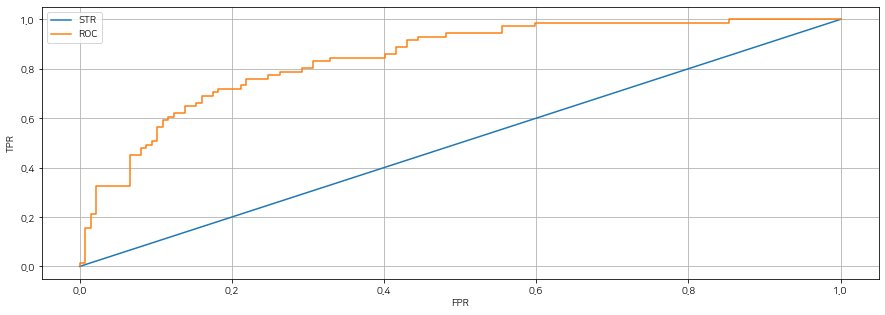

In [205]:
pred_positive_label = full_lr.predict_proba(X_test)[:,1]
fprs, tprs, thresholds = roc_curve(y_test, pred_positive_label)

precisions, recalls, thresholds = roc_curve(y_test, pred_positive_label)
plt.figure(figsize=(15,5))

# 대각선

plt.plot([0,1],[0,1],label='STR')

# ROC
plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()

plt.show()

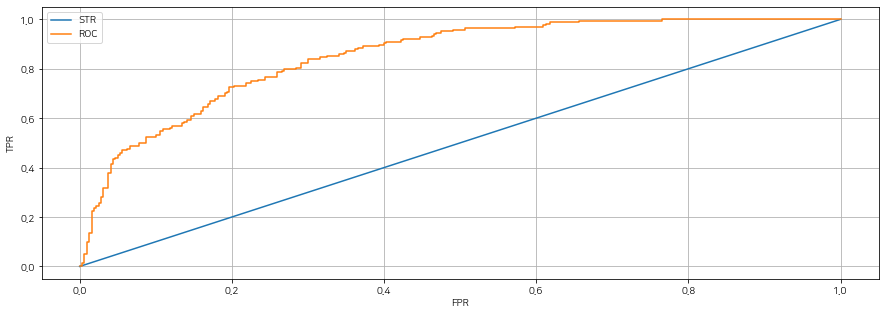

In [206]:
pred_positive_label_trn = full_lr.predict_proba(X_train)[:,1]
fprs, tprs, thresholds = roc_curve(y_train, pred_positive_label_trn)

precisions, recalls, thresholds = roc_curve(y_train, pred_positive_label_trn)
plt.figure(figsize=(15,5))

# 대각선

plt.plot([0,1],[0,1],label='STR')

# ROC
plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()

plt.show()

In [215]:
roc_auc_score(y_train, trn_response)

0.7078125000000001

In [216]:
roc_auc_score(y_test, y_pred)

0.716510743291868

In [217]:
corr_col = ['Glucose', 'BMI', 'DiabetesPedigreeFunction']

In [220]:
corr_lr = LogisticRegression(
    solver='liblinear',
    random_state=2019170812,
    max_iter=1e+7
)
corr_trn = X_train.loc[:, corr_col]

# Train the model with trainset
corr_lr.fit(corr_trn ,y_train)


LogisticRegression(max_iter=10000000.0, random_state=2019170812,
                   solver='liblinear')

In [221]:
logit_pvalue(corr_lr,corr_trn,corr_col)

,P-value
constant,0.0000
Glucose,0.0000
BMI,0.0024
DiabetesPedigreeFunction,0.0481


{'constant': 0.0,
 'Glucose': 0.0,
 'BMI': 0.0024,
 'DiabetesPedigreeFunction': 0.0481}

In [222]:
corr_response = corr_lr.predict(corr_trn)
cm_trn = confusion_matrix(y_train,corr_response)
cm_trn

array([[297,  23],
       [ 85,  79]])

In [227]:
clf_results = perf_eval_clf(y_train,corr_response)
result_dict['P-value Training'] = clf_results
display_result(result_dict,metric_names)

,TPR(Recall),Precision,TNR,ACC,BCR,F1
Test_set,0.5352,0.7308,0.8978,0.7740,0.6932,0.6179
Train_set,0.5000,0.7523,0.9156,0.7748,0.6766,0.6007
Diabetes,0.4817,0.7745,0.9281,0.7769,0.6686,0.5940
P-value Training,0.4817,0.7745,0.9281,0.7769,0.6686,0.5940


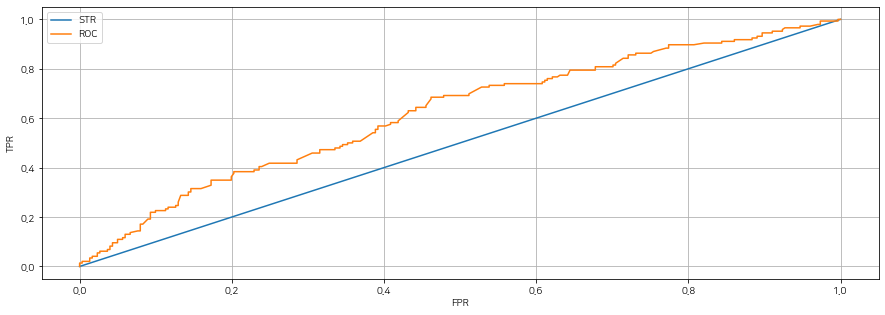

In [48]:
pred_positive_label_corr = corr_lr.predict_proba(corr_trn)[:,1]
fprs, tprs, thresholds = roc_curve(y_trn, pred_positive_label_corr)

precisions, recalls, thresholds = roc_curve(y_trn, pred_positive_label_corr)
plt.figure(figsize=(15,5))

# 대각선

plt.plot([0,1],[0,1],label='STR')

# ROC
plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()

plt.show()

In [229]:
roc_auc_score(y_train, corr_response)

0.7049161585365854

In [226]:
corr_tst_response = corr_lr.predict(X_test.loc[:,corr_col])
cm_trn = confusion_matrix(y_test,corr_tst_response)
cm_trn

array([[129,   8],
       [ 39,  32]])

In [228]:
clf_results = perf_eval_clf(y_test,corr_tst_response)
result_dict['P-value Test'] = clf_results
display_result(result_dict,metric_names)

,TPR(Recall),Precision,TNR,ACC,BCR,F1
Test_set,0.5352,0.7308,0.8978,0.7740,0.6932,0.6179
Train_set,0.5000,0.7523,0.9156,0.7748,0.6766,0.6007
Diabetes,0.4817,0.7745,0.9281,0.7769,0.6686,0.5940
P-value Training,0.4817,0.7745,0.9281,0.7769,0.6686,0.5940
P-value Test,0.4507,0.8000,0.9416,0.7740,0.6514,0.5766


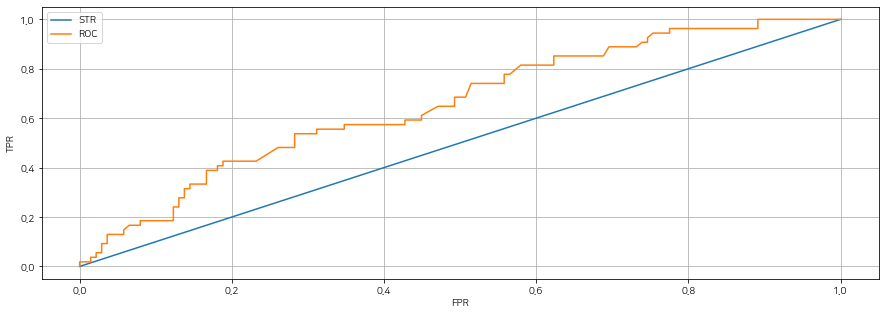

In [52]:
pred_positive_label_corr_tst = corr_lr.predict_proba(x_tst.loc[:,corr_col])[:,1]
fprs, tprs, thresholds = roc_curve(y_tst, pred_positive_label_corr_tst)

precisions, recalls, thresholds = roc_curve(y_tst, pred_positive_label_corr_tst)
plt.figure(figsize=(15,5))

# 대각선

plt.plot([0,1],[0,1],label='STR')

# ROC
plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()

plt.show()

In [230]:
roc_auc_score(y_test, corr_tst_response)

0.6961550323840855

### K-Nearest Neighbor Classifier

In [242]:
param_grid = {
    'n_neighbors' : [3,5,7,10],
    'weights' : ['uniform', 'distance']
}

In [243]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
# Fit the decision tree model and evaluate the results

grid = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', refit=True)
grid.fit(X_train, y_train)

# Find the best set of parameters
best_n_neighbors = grid.best_params_['n_neighbors']
best_weights = grid.best_params_['weights']

print("Best N_neighbors:", best_n_neighbors)
print("Best weights:", best_weights)

# Evaluate the best model on the validation data
y_pred = grid.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)

# Print results
print("Confusion matrix:\n", cm)
print("ROC AUC:", roc)

Best N_neighbors: 10
Best weights: distance
Confusion matrix:
 [[112  25]
 [ 28  43]]
ROC AUC: 0.7115760254960419


In [238]:
clf_results = perf_eval_clf(y_test, y_pred)
result_dict['KNN'] = clf_results
display_result(result_dict,metric_names)

,TPR(Recall),Precision,TNR,ACC,BCR,F1
Test_set,0.5352,0.7308,0.8978,0.7740,0.6932,0.6179
Train_set,0.5000,0.7523,0.9156,0.7748,0.6766,0.6007
Diabetes,0.4817,0.7745,0.9281,0.7769,0.6686,0.5940
P-value Training,0.4817,0.7745,0.9281,0.7769,0.6686,0.5940
P-value Test,0.4507,0.8000,0.9416,0.7740,0.6514,0.5766
KNN,0.6056,0.6324,0.8175,0.7452,0.7036,0.6187


### SVM

In [245]:
param_grid = {
    'penalty' : ['l1','l2'],
    'C' : [0.25, 0.5, 1]
}

In [247]:
from sklearn.svm import LinearSVC

model = LinearSVC()
# Fit the decision tree model and evaluate the results

grid = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', refit=True)
grid.fit(X_train, y_train)

# Find the best set of parameters
best_penalty = grid.best_params_['penalty']
best_C = grid.best_params_['C']

print("Best penalty:", best_penalty)
print("Best C:", best_C)

# Evaluate the best model on the validation data
y_pred = grid.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)

# Print results
print("Confusion matrix:\n", cm)
print("ROC AUC:", roc)

Best penalty: l2
Best C: 1
Confusion matrix:
 [[122  15]
 [ 29  42]]
ROC AUC: 0.7410301223398787


In [248]:
clf_results = perf_eval_clf(y_test, y_pred)
result_dict['SVM'] = clf_results
display_result(result_dict,metric_names)

,TPR(Recall),Precision,TNR,ACC,BCR,F1
Test_set,0.5352,0.7308,0.8978,0.7740,0.6932,0.6179
Train_set,0.5000,0.7523,0.9156,0.7748,0.6766,0.6007
Diabetes,0.4817,0.7745,0.9281,0.7769,0.6686,0.5940
P-value Training,0.4817,0.7745,0.9281,0.7769,0.6686,0.5940
P-value Test,0.4507,0.8000,0.9416,0.7740,0.6514,0.5766
KNN,0.6056,0.6324,0.8175,0.7452,0.7036,0.6187
SVM,0.5915,0.7368,0.8905,0.7885,0.7258,0.6562


In [252]:
param_grid = {
    'kernel' : ['rbf','poly', 'sigmoid'],
    'C' : [0.25, 0.5, 1]
}


In [254]:
from sklearn.svm import SVC

model = SVC()
# Fit the decision tree model and evaluate the results

grid = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', refit=True)
grid.fit(X_train, y_train)

# Find the best set of parameters
best_kernel = grid.best_params_['kernel']
best_C = grid.best_params_['C']

print("Best kernel:", best_kernel)
print("Best C:", best_C)

# Evaluate the best model on the validation data
y_pred = grid.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)

# Print results
print("Confusion matrix:\n", cm)
print("ROC AUC:", roc)


Best kernel: rbf
Best C: 0.5
Confusion matrix:
 [[120  17]
 [ 32  39]]
ROC AUC: 0.7126040917035058


In [255]:
clf_results = perf_eval_clf(y_test, y_pred)
result_dict['SVM_kernel'] = clf_results
display_result(result_dict,metric_names)

,TPR(Recall),Precision,TNR,ACC,BCR,F1
Test_set,0.5352,0.7308,0.8978,0.7740,0.6932,0.6179
Train_set,0.5000,0.7523,0.9156,0.7748,0.6766,0.6007
Diabetes,0.4817,0.7745,0.9281,0.7769,0.6686,0.5940
P-value Training,0.4817,0.7745,0.9281,0.7769,0.6686,0.5940
P-value Test,0.4507,0.8000,0.9416,0.7740,0.6514,0.5766
KNN,0.6056,0.6324,0.8175,0.7452,0.7036,0.6187
SVM,0.5915,0.7368,0.8905,0.7885,0.7258,0.6562
SVM_kernel,0.5493,0.6964,0.8759,0.7644,0.6936,0.6142


### Decision Tree

In [256]:
# Classification and Regression Tree (CART) --------------------------------------
# Training the tree
clf = DecisionTreeClassifier(random_state=2019170812)
CART_full = clf.fit(X_train, y_train)

In [257]:
clf.score(X_train, y_train)

1.0

In [258]:
clf.score(X_test, y_test)

0.7307692307692307

In [262]:
# Prediction
y_pred = CART_full.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[111,  26],
       [ 30,  41]])

In [291]:
clf_results = perf_eval_clf(y_test, y_pred)
result_dict['Full_CART'] = clf_results
display_result(result_dict,metric_names)

,TPR(Recall),Precision,TNR,ACC,BCR,F1
Test_set,0.5352,0.7308,0.8978,0.7740,0.6932,0.6179
Train_set,0.5000,0.7523,0.9156,0.7748,0.6766,0.6007
Diabetes,0.4817,0.7745,0.9281,0.7769,0.6686,0.5940
P-value Training,0.4817,0.7745,0.9281,0.7769,0.6686,0.5940
P-value Test,0.4507,0.8000,0.9416,0.7740,0.6514,0.5766
KNN,0.6056,0.6324,0.8175,0.7452,0.7036,0.6187
SVM,0.5915,0.7368,0.8905,0.7885,0.7258,0.6562
SVM_kernel,0.5493,0.6964,0.8759,0.7644,0.6936,0.6142
Full_CART,0.5775,0.6119,0.8102,0.7308,0.6840,0.5942
Post_Pruning,0.6620,0.6912,0.8467,0.7837,0.7487,0.6763


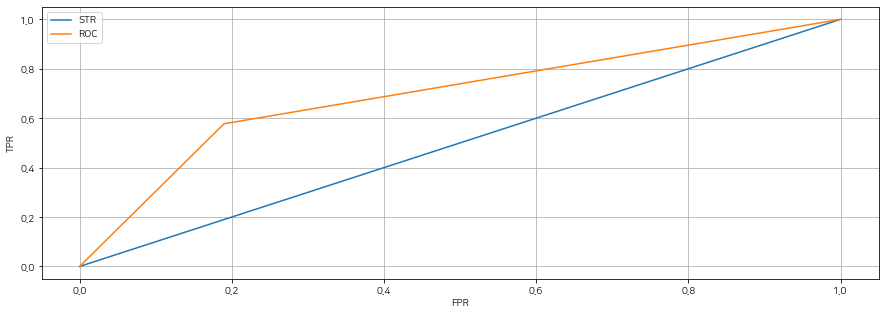

In [292]:
pred_positive_label = CART_full.predict_proba(X_test)[:,1]
fprs, tprs, thresholds = roc_curve(y_test, pred_positive_label)

precisions, recalls, thresholds = roc_curve(y_test, pred_positive_label)
plt.figure(figsize=(15,5))

# 대각선

plt.plot([0,1],[0,1],label='STR')

# ROC
plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()

plt.show()

In [264]:
cm

array([[111,  26],
       [ 30,  41]])

In [265]:
roc = roc_auc_score(y_test, y_pred)

# Print results
print("ROC AUC:", roc)

ROC AUC: 0.6938418834172921


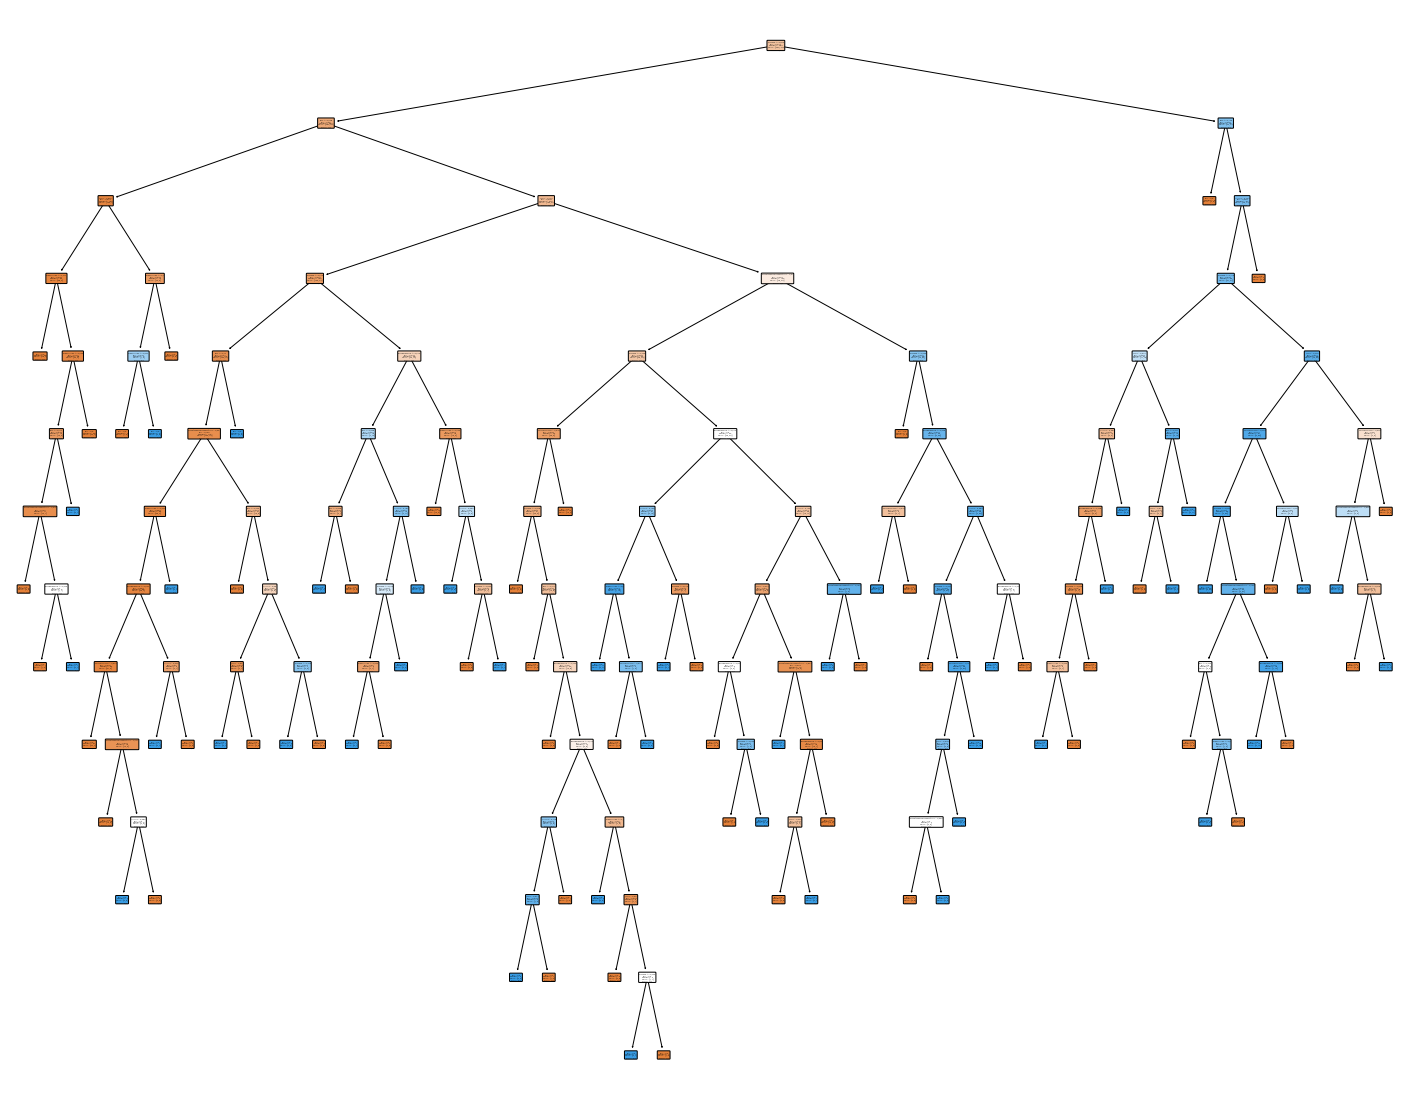

In [267]:
# Plot the tree
fig = plt.figure(figsize=(25,20))
_ = plot_tree(clf,
              feature_names=df.columns.values,
              class_names=list(map(str, df_target.unique())),
              rounded=True,
              filled=True)
plt.show()

In [271]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

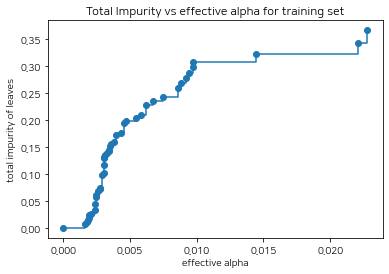

In [272]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

In [273]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=12345, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.08180330129573582


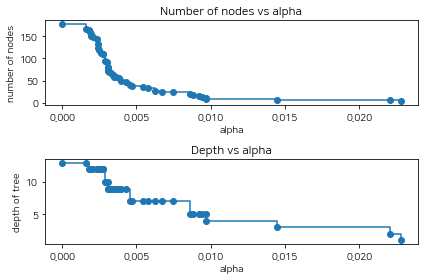

In [274]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

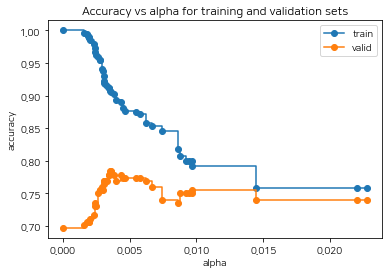

In [276]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and validation sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="valid", drawstyle="steps-post")
ax.legend()
plt.show()

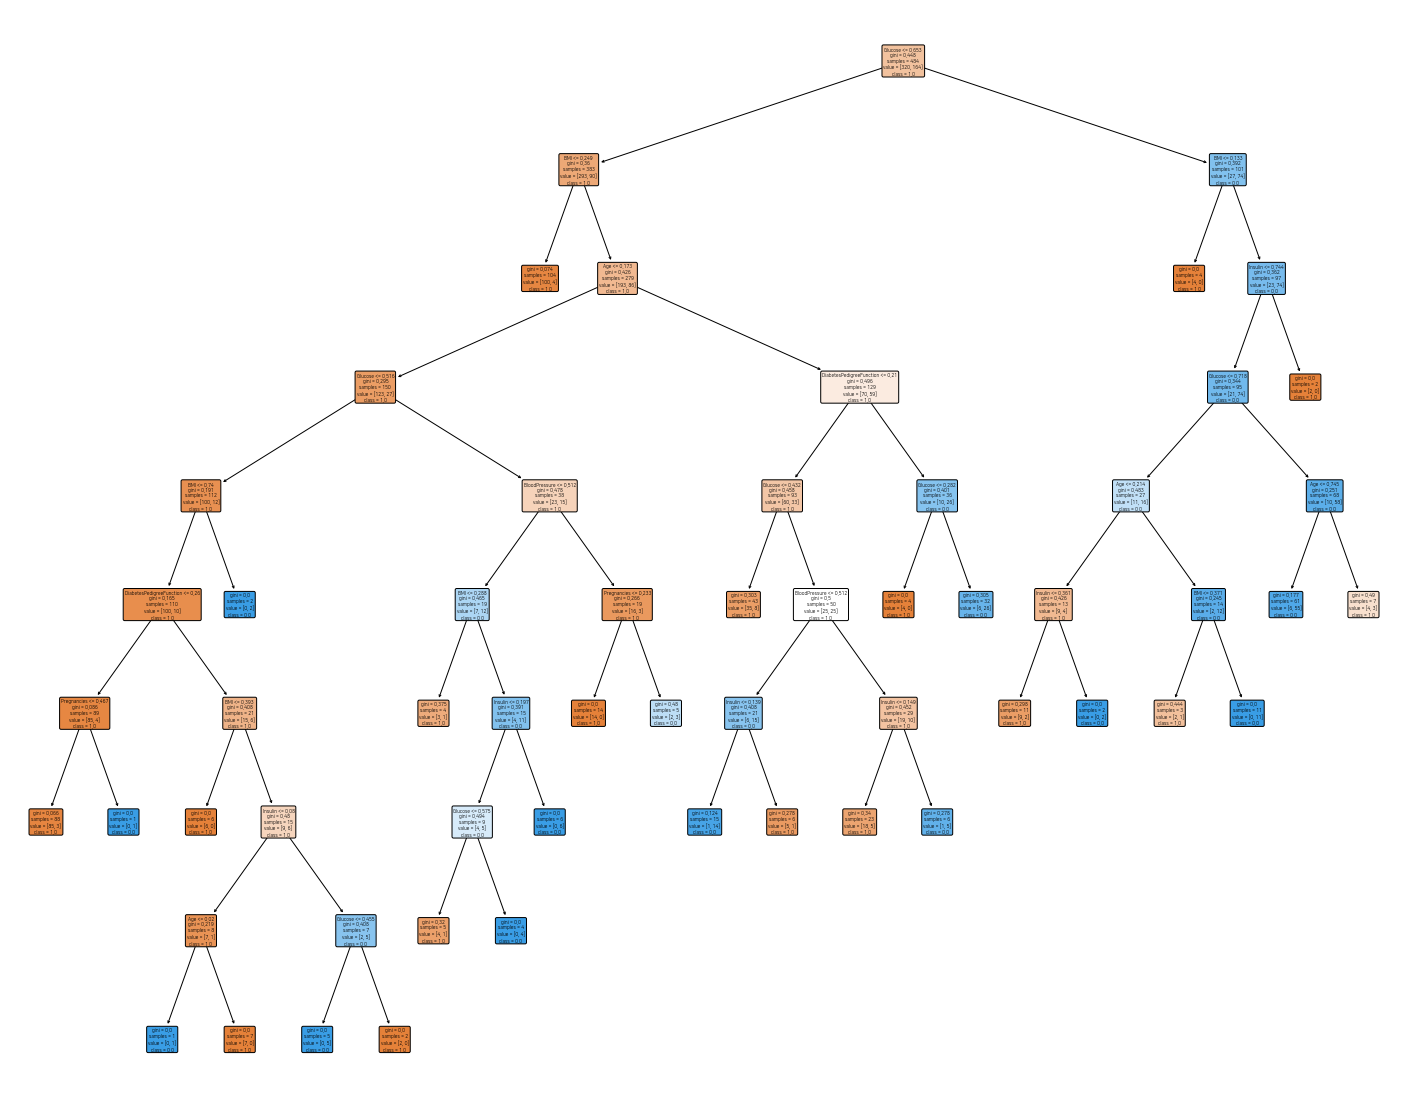

In [286]:
best_clf = clfs[np.argmax(test_scores)]

fig = plt.figure(figsize=(25,20))
_ = plot_tree(best_clf,
              feature_names=df_input.columns.values,
              class_names=list(map(str, df_target.unique())),
              rounded=True,
              filled=True)

In [287]:
# Prediction
CART_post_prey = best_clf.predict(X_test)
cm = confusion_matrix(y_test, CART_post_prey)
clf_results = perf_eval_clf(y_test, CART_post_prey)
result_dict['Post_Pruning'] = clf_results
display_result(result_dict,metric_names)

,TPR(Recall),Precision,TNR,ACC,BCR,F1
Test_set,0.5352,0.7308,0.8978,0.7740,0.6932,0.6179
Train_set,0.5000,0.7523,0.9156,0.7748,0.6766,0.6007
Diabetes,0.4817,0.7745,0.9281,0.7769,0.6686,0.5940
P-value Training,0.4817,0.7745,0.9281,0.7769,0.6686,0.5940
P-value Test,0.4507,0.8000,0.9416,0.7740,0.6514,0.5766
KNN,0.6056,0.6324,0.8175,0.7452,0.7036,0.6187
SVM,0.5915,0.7368,0.8905,0.7885,0.7258,0.6562
SVM_kernel,0.5493,0.6964,0.8759,0.7644,0.6936,0.6142
Full_CART,0.5775,0.6119,0.8102,0.7308,0.6840,0.5942
Post_Pruning,0.6620,0.6912,0.8467,0.7837,0.7487,0.6763


In [288]:
cm

array([[116,  21],
       [ 24,  47]])

In [289]:
roc = roc_auc_score(y_test, CART_post_prey)

# Print results
print("ROC AUC:", roc)

ROC AUC: 0.7543435797265343


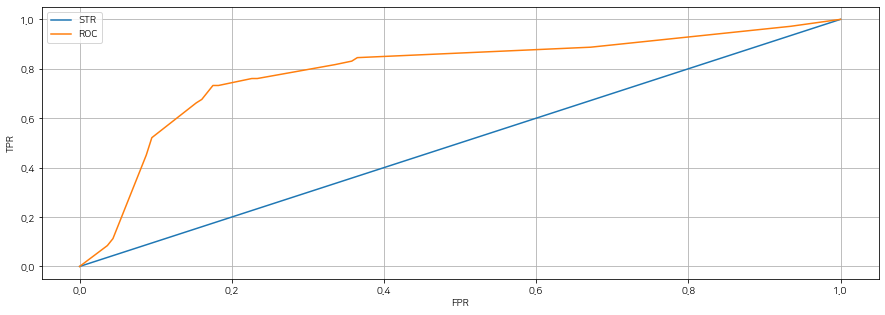

In [293]:
pred_positive_label = best_clf.predict_proba(X_test)[:,1]
fprs, tprs, thresholds = roc_curve(y_test, pred_positive_label)

precisions, recalls, thresholds = roc_curve(y_test, pred_positive_label)
plt.figure(figsize=(15,5))

# 대각선

plt.plot([0,1],[0,1],label='STR')

# ROC
plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()

plt.show()

In [294]:
# Tree parameter settings
criterion = ["gini", "entropy", "log_loss"]
min_split = [10, 20, 30, 50]
max_depth = [5, 10, 15]
min_leaf = [3, 5, 10]

param_grid = {
    'criterion': criterion,
    'min_samples_split': min_split,
    'min_samples_leaf': min_leaf,
    'max_depth': max_depth
}

In [296]:
# Fit the decision tree model and etestuate the results
model = DecisionTreeClassifier(random_state=12345)
grid = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', refit=True)
grid.fit(X_train, y_train)

# Find the best set of parameters
best_criterion = grid.best_params_['criterion']
best_split = grid.best_params_['min_samples_split']
best_depth = grid.best_params_['max_depth']
best_leaf = grid.best_params_['min_samples_leaf']

print("Best criterion:", best_criterion)
print("Best min_samples_split:", best_split)
print("Best max_depth:", best_depth)
print("Best min_samples_leaf:", best_leaf)


y_pred = grid.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)

# Print results
print("Confusion matrix:\n", cm)
print("ROC AUC:", roc)

Best criterion: gini
Best min_samples_split: 50
Best max_depth: 5
Best min_samples_leaf: 3
Confusion matrix:
 [[115  22]
 [ 31  40]]
ROC AUC: 0.7013981700421508


In [297]:
# Prediction
CART_pre_prediction = grid.predict(X_test)
cm = confusion_matrix(y_test, CART_pre_prediction)
clf_results = perf_eval_clf(y_test, CART_pre_prediction)
result_dict['Pre_Pruning'] = clf_results
display_result(result_dict,metric_names)

,TPR(Recall),Precision,TNR,ACC,BCR,F1
Test_set,0.5352,0.7308,0.8978,0.7740,0.6932,0.6179
Train_set,0.5000,0.7523,0.9156,0.7748,0.6766,0.6007
Diabetes,0.4817,0.7745,0.9281,0.7769,0.6686,0.5940
P-value Training,0.4817,0.7745,0.9281,0.7769,0.6686,0.5940
P-value Test,0.4507,0.8000,0.9416,0.7740,0.6514,0.5766
KNN,0.6056,0.6324,0.8175,0.7452,0.7036,0.6187
SVM,0.5915,0.7368,0.8905,0.7885,0.7258,0.6562
SVM_kernel,0.5493,0.6964,0.8759,0.7644,0.6936,0.6142
Full_CART,0.5775,0.6119,0.8102,0.7308,0.6840,0.5942
Post_Pruning,0.6620,0.6912,0.8467,0.7837,0.7487,0.6763


In [298]:
cm

array([[115,  22],
       [ 31,  40]])

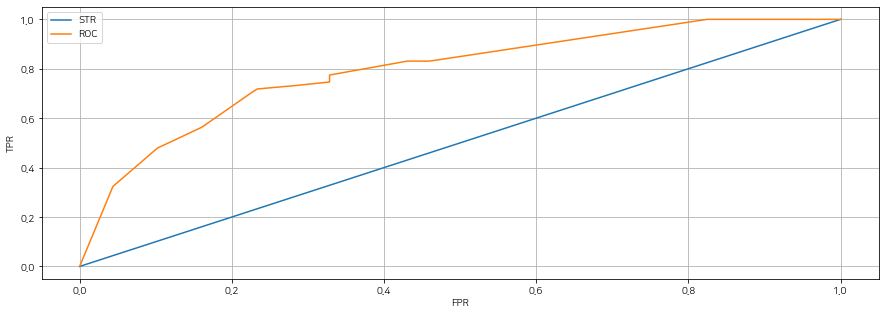

In [300]:
# Plot the ROC
pred_positive_label = grid.predict_proba(X_test)[:,1]
fprs, tprs, thresholds = roc_curve(y_test, pred_positive_label)

precisions, recalls, thresholds = roc_curve(y_test, pred_positive_label)
plt.figure(figsize=(15,5))

# 대각선

plt.plot([0,1],[0,1],label='STR')

# ROC
plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()

plt.show()

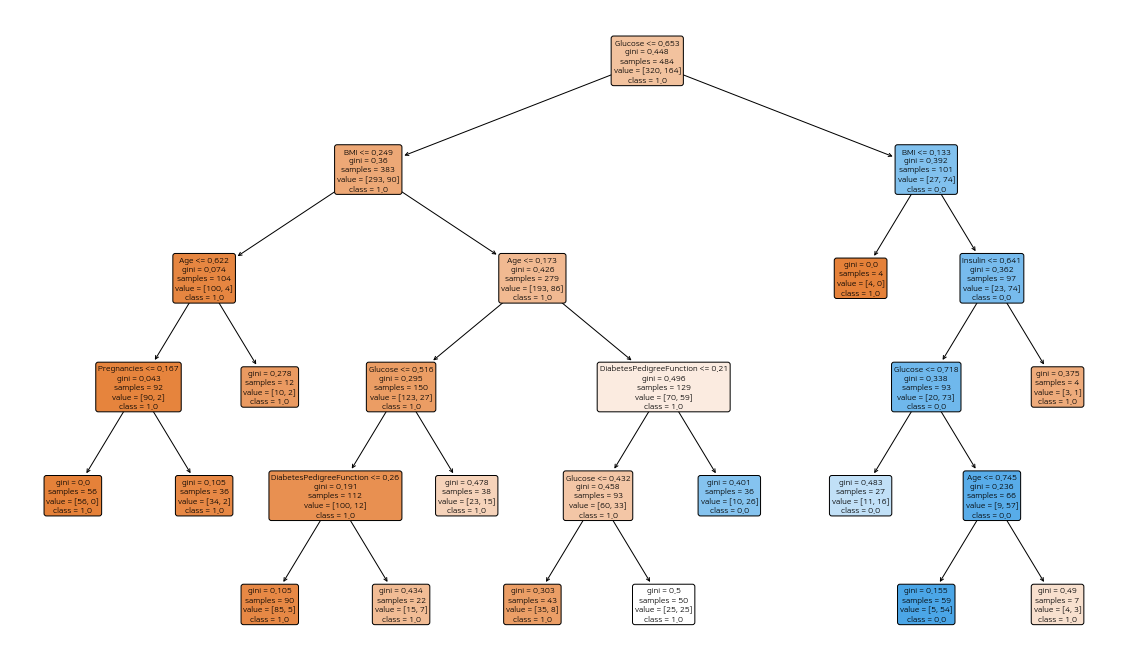

In [301]:
# Plot the best tree
CART_pre = DecisionTreeClassifier(**grid.best_params_)
CART_pre.fit(X_train,y_train)
plt.figure(figsize=(20,12))
plot_tree(CART_pre,
          feature_names=df_input.columns.values,
          class_names=list(map(str, df_target.unique())),
          rounded=True,
          filled=True)
plt.show()

In [302]:
from sklearn.neural_network import MLPClassifier

parameters = {'solver': ['lbfgs', 'adam', 'sgd'], 'max_iter': [500,1000,1500], 'alpha': 10.0 ** -np.arange(3, 6), 'hidden_layer_sizes':[5,10,15]}

### Neural Network

In [304]:
# Fit the decision tree model and evaluate the results
model = MLPClassifier(random_state=12345)
grid_mlp = GridSearchCV(model, parameters, cv=5, scoring='roc_auc', refit=True)
grid_mlp.fit(X_train, y_train)

# Find the best set of parameters
best_solver = grid_mlp.best_params_['solver']
best_iter = grid_mlp.best_params_['max_iter']
best_alpha = grid_mlp.best_params_['alpha']
best_hidden_size = grid_mlp.best_params_['hidden_layer_sizes']

print("Best solver:", best_solver)
print("Best max_iters:", best_iter)
print("Best Learning-rate:", best_alpha)
print("Best Hidden Layer Sizes:", best_hidden_size)

# Evaluate the best model on the validation data
y_pred = grid_mlp.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)

# Print results
print("Confusion matrix:\n", cm)
print("ROC AUC:", roc)

Best solver: adam
Best max_iters: 1000
Best Learning-rate: 0.001
Best Hidden Layer Sizes: 5
Confusion matrix:
 [[122  15]
 [ 28  43]]
ROC AUC: 0.7480723758610055


In [305]:
# Prediction
clf_results = perf_eval_clf(y_test, y_pred)
result_dict['ANN'] = clf_results
display_result(result_dict,metric_names)

,TPR(Recall),Precision,TNR,ACC,BCR,F1
Test_set,0.5352,0.7308,0.8978,0.7740,0.6932,0.6179
Train_set,0.5000,0.7523,0.9156,0.7748,0.6766,0.6007
Diabetes,0.4817,0.7745,0.9281,0.7769,0.6686,0.5940
P-value Training,0.4817,0.7745,0.9281,0.7769,0.6686,0.5940
P-value Test,0.4507,0.8000,0.9416,0.7740,0.6514,0.5766
KNN,0.6056,0.6324,0.8175,0.7452,0.7036,0.6187
SVM,0.5915,0.7368,0.8905,0.7885,0.7258,0.6562
SVM_kernel,0.5493,0.6964,0.8759,0.7644,0.6936,0.6142
Full_CART,0.5775,0.6119,0.8102,0.7308,0.6840,0.5942
Post_Pruning,0.6620,0.6912,0.8467,0.7837,0.7487,0.6763


In [307]:
parameters = {'solver': ['lbfgs', 'adam', 'sgd'], 'max_iter': [500,1000,1500], 'alpha': 10.0 ** -np.arange(3, 6), 'hidden_layer_sizes':[(5,),(5,5,0),(5,5,5)]}

In [308]:
# Fit the decision tree model and evaluate the results
model = MLPClassifier(random_state=12345)
grid_mlp = GridSearchCV(model, parameters, cv=5, scoring='roc_auc', refit=True)
grid_mlp.fit(X_train, y_train)

# Find the best set of parameters
best_solver = grid_mlp.best_params_['solver']
best_iter = grid_mlp.best_params_['max_iter']
best_alpha = grid_mlp.best_params_['alpha']
best_hidden_size = grid_mlp.best_params_['hidden_layer_sizes']

print("Best solver:", best_solver)
print("Best max_iters:", best_iter)
print("Best Learning-rate:", best_alpha)
print("Best Hidden Layer Sizes:", best_hidden_size)

# Evaluate the best model on the validation data
y_pred = grid_mlp.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)

# Print results
print("Confusion matrix:\n", cm)
print("ROC AUC:", roc)

Best solver: adam
Best max_iters: 1000
Best Learning-rate: 0.001
Best Hidden Layer Sizes: (5,)
Confusion matrix:
 [[122  15]
 [ 28  43]]
ROC AUC: 0.7480723758610055


### Ensemble

In [306]:
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier

In [313]:
# Performance table
CART_Perf = pd.DataFrame(index=[f'BootStrap({i*30})' for i in range(1,11)],
                          columns = ['TPR(Recall)','Precision','TNR','ACC','BCR','F1'])

In [314]:
for i in range(10):
    bagging_dt_model = BaggingClassifier(
        base_estimator = best_clf,
        n_estimators   = 30*(i+1),
        n_jobs         = 8, # Assign the number of cores to be processed in parallel
        bootstrap      = True,
        verbose        = 1
    ).fit(X=X_train, y=y_train)
    bagging_dt_prey = bagging_dt_model.predict(X=X_test)
    bagging_dt_cfm = confusion_matrix(y_true=y_test, y_pred=bagging_dt_prey)
    CART_Perf.iloc[i] = perf_eval_clf(y_test, bagging_dt_prey)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Don

In [315]:
CART_Perf

,TPR(Recall),Precision,TNR,ACC,BCR,F1
BootStrap(30),0.6056,0.6615,0.8394,0.7596,0.713,0.6323
BootStrap(60),0.6479,0.6389,0.8102,0.7548,0.7245,0.6434
BootStrap(90),0.6479,0.6667,0.8321,0.7692,0.7342,0.6572
BootStrap(120),0.5915,0.6269,0.8175,0.7404,0.6954,0.6087
BootStrap(150),0.6056,0.6719,0.8467,0.7644,0.7161,0.637
BootStrap(180),0.6197,0.6667,0.8394,0.7644,0.7212,0.6423
BootStrap(210),0.5915,0.6562,0.8394,0.7548,0.7046,0.6222
BootStrap(240),0.662,0.6528,0.8175,0.7644,0.7357,0.6574
BootStrap(270),0.6056,0.6515,0.8321,0.7548,0.7099,0.6277
BootStrap(300),0.6479,0.6479,0.8175,0.7596,0.7278,0.6479


In [316]:
CART_Perf.to_csv('CART_Perf.csv')

In [322]:
RanFor_Perf = pd.DataFrame(index=[f'BootStrap({i*30})' for i in range(1,11)],
                          columns = ['TPR(Recall)','Precision','TNR','ACC','BCR','F1'])

In [323]:

for i in range(10):
    bagging_rf_model = RandomForestClassifier(
        n_estimators   = 30*(i+1),
        n_jobs         = 8, # Assign the number of cores to be processed in
        bootstrap      = True,
        verbose        = 1
    ).fit(X=X_train, y=y_train)

    bagging_rf_prey = bagging_rf_model.predict(X=X_test)
    RanFor_Perf.iloc[i] = perf_eval_clf(y_test, bagging_rf_prey)


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  90 out of  90 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurr

In [324]:
RanFor_Perf

,TPR(Recall),Precision,TNR,ACC,BCR,F1
BootStrap(30),0.507,0.6316,0.8467,0.7308,0.6552,0.5625
BootStrap(60),0.6056,0.6719,0.8467,0.7644,0.7161,0.637
BootStrap(90),0.6338,0.7031,0.8613,0.7837,0.7388,0.6667
BootStrap(120),0.5775,0.6721,0.854,0.7596,0.7023,0.6212
BootStrap(150),0.5915,0.6462,0.8321,0.75,0.7016,0.6176
BootStrap(180),0.6056,0.6825,0.854,0.7692,0.7192,0.6418
BootStrap(210),0.6338,0.6923,0.854,0.7788,0.7357,0.6618
BootStrap(240),0.5775,0.6508,0.8394,0.75,0.6962,0.612
BootStrap(270),0.6056,0.6719,0.8467,0.7644,0.7161,0.637
BootStrap(300),0.6056,0.6515,0.8321,0.7548,0.7099,0.6277


In [325]:
RanFor_Perf.to_csv('RanFor_Perf.csv')

Text(0.5, 1.0, 'Accuracy of RandomForest and CART')

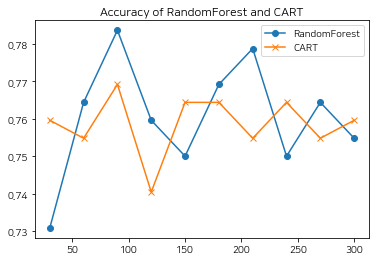

In [328]:
plt.plot([(i+1)*30 for i in range (10)], RanFor_Perf['ACC'],label='RandomForest', marker ='o')
plt.plot([(i+1)*30 for i in range (10)], CART_Perf['ACC'], label='CART', marker ='x')
plt.legend()
plt.title("Accuracy of RandomForest and CART")

In [329]:
AdaBoost_Perf = pd.DataFrame(index=[f'BootStrap({i*30})' for i in range(1,11)],
                          columns = ['TPR(Recall)','Precision','TNR','ACC','BCR','F1'])

In [338]:
parameters = {'n_estimators' : [30, 60, 90, 120, 150],
              'learning_rate': [0.1,0.5,1.0],
              'base_estimator__max_depth': [1, 2, 3]}

In [339]:
# Fit the decision tree model and evaluate the results
model = AdaBoostClassifier(
    base_estimator = DecisionTreeClassifier(),
)
grid_adaboost = GridSearchCV(model, parameters, cv=5, scoring='roc_auc', refit=True)
grid_adaboost.fit(X_train, y_train)

# Find the best set of parameters

best_n_estimators = grid_adaboost.best_params_['n_estimators']
best_learning_rate = grid_adaboost.best_params_['learning_rate']
best_max_depth = grid_adaboost.best_params_['base_estimator__max_depth']

print("Best n_estimators:", best_n_estimators)
print("Best learning rate:", best_learning_rate)
print("Best Max Depth:", best_max_depth)

# Evaluate the best model on the validation data
y_pred = grid_adaboost.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
# Print results
clf_results = perf_eval_clf(y_test, y_pred)
result_dict['AdaBoost'] = clf_results
display_result(result_dict,metric_names)

Best n_estimators: 120
Best learning rate: 0.1
Best Max Depth: 1
[[118  19]
 [ 28  43]]


,TPR(Recall),Precision,TNR,ACC,BCR,F1
Test_set,0.5352,0.7308,0.8978,0.7740,0.6932,0.6179
Train_set,0.5000,0.7523,0.9156,0.7748,0.6766,0.6007
Diabetes,0.4817,0.7745,0.9281,0.7769,0.6686,0.5940
P-value Training,0.4817,0.7745,0.9281,0.7769,0.6686,0.5940
P-value Test,0.4507,0.8000,0.9416,0.7740,0.6514,0.5766
KNN,0.6056,0.6324,0.8175,0.7452,0.7036,0.6187
SVM,0.5915,0.7368,0.8905,0.7885,0.7258,0.6562
SVM_kernel,0.5493,0.6964,0.8759,0.7644,0.6936,0.6142
Full_CART,0.5775,0.6119,0.8102,0.7308,0.6840,0.5942
Post_Pruning,0.6620,0.6912,0.8467,0.7837,0.7487,0.6763


In [335]:
parameters = {'n_estimators' : [30, 60, 90, 120, 150],
              'learning_rate': [0.1,0.5,1],
              'max_depth': [1, 2, 3]}

In [336]:
# Training GBM
# Fit the decision tree model and evaluate the results
model = GradientBoostingClassifier(random_state=12345)
grid_gbm = GridSearchCV(model, parameters, cv=5, scoring='roc_auc', refit=True)
grid_gbm.fit(X_train, y_train)

# Find the best set of parameters

best_n_estimators = grid_gbm.best_params_['n_estimators']
best_learning_rate = grid_gbm.best_params_['learning_rate']
best_max_depth = grid_gbm.best_params_['max_depth']

print("Best n_estimators:", best_n_estimators)
print("Best learning rate:", best_learning_rate)
print("Best Max Depth:", best_max_depth)

print("Best n_estimators:", best_n_estimators)

# Evaluate the best model on the validation data
y_pred = grid_gbm.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Print results
print("Confusion matrix:\n", cm)
clf_results = perf_eval_clf(y_test, y_pred)
result_dict['GradientBoost'] = clf_results
display_result(result_dict,metric_names)

Best n_estimators: 60
Best learning rate: 0.1
Best Max Depth: 1
Best n_estimators: 60
Confusion matrix:
 [[124  13]
 [ 38  33]]


,TPR(Recall),Precision,TNR,ACC,BCR,F1
Test_set,0.5352,0.7308,0.8978,0.7740,0.6932,0.6179
Train_set,0.5000,0.7523,0.9156,0.7748,0.6766,0.6007
Diabetes,0.4817,0.7745,0.9281,0.7769,0.6686,0.5940
P-value Training,0.4817,0.7745,0.9281,0.7769,0.6686,0.5940
P-value Test,0.4507,0.8000,0.9416,0.7740,0.6514,0.5766
KNN,0.6056,0.6324,0.8175,0.7452,0.7036,0.6187
SVM,0.5915,0.7368,0.8905,0.7885,0.7258,0.6562
SVM_kernel,0.5493,0.6964,0.8759,0.7644,0.6936,0.6142
Full_CART,0.5775,0.6119,0.8102,0.7308,0.6840,0.5942
Post_Pruning,0.6620,0.6912,0.8467,0.7837,0.7487,0.6763


In [341]:
result_dict = pd.DataFrame(result_dict).T
result_dict.to_csv('result_dict.csv')